## For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.|

In [3]:
!pip install wikipedia

In [4]:
!pip install folium

     |████████████████████████████████| 102kB 6.8MB/s ta 0:00:011


In [5]:
!pip install shapely

     |████████████████████████████████| 1.8MB 23.2MB/s eta 0:00:01


In [6]:
!pip install geopandas

     |████████████████████████████████| 931kB 9.8MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 9.3MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 25.3MB/s eta 0:00:01


In [7]:
import pandas as pd 
import wikipedia as wp
from bs4 import BeautifulSoup

import requests
import io

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from shapely.geometry import Point
import geopandas as gpd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import matplotlib.pyplot as plt


# setup import
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [86]:
import numpy as np

In [8]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")

In [9]:
# determine the index of your table
df = pd.read_html(html, header = 0)[0]

In [10]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [11]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [12]:
df.loc[df.Neighborhood == 'Not assigned']

,Postal Code,Borough,Neighborhood


In [13]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

df.Neighborhood.replace('Not assigned',df.Borough,inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [14]:
#Group Neighbourhoods with the same Postcode

df_toronto = df.groupby(['Postal Code', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x))
df_toronto = df_toronto.reset_index()
df_toronto.rename(columns = {'Postal Code':'Postal Code'}, inplace = True)
df_toronto.rename(columns = {'Neighborhood':'Neighborhood'}, inplace = True)
df_toronto.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [15]:
df_toronto.shape

(103, 3)

In [16]:
# in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.
url="http://cocl.us/Geospatial_data"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [17]:
# rename the first column to allow merging dataframes on Postcode
c.columns = ['Postal Code', 'Latitude', 'Longitude']
df_ll = pd.merge(c, df_toronto, on='Postal Code')

# reorder column names and show the dataframe
df_ll = df_ll[['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
df_ll.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [18]:
# load latitude and longitude into geopandas dataframe
df_ll['Coordinates'] = list(zip(df_ll.Longitude, df_ll.Latitude))
df_ll['Coordinates'] = df_ll['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df_ll, geometry='Coordinates')
df_ll.head(4)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Coordinates
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,POINT (-79.19435 43.80669)
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,POINT (-79.16050 43.78454)
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,POINT (-79.18871 43.76357)
3,M1G,Scarborough,Woburn,43.770992,-79.216917,POINT (-79.21692 43.77099)


/opt/conda/envs/Python36/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


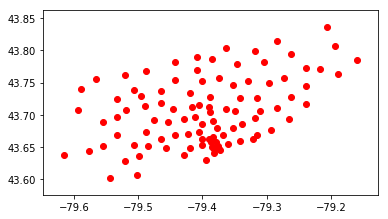

In [19]:
# set up map
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='white', edgecolor='black')

# plot and show
gdf.plot(ax=ax, color='red')
plt.show()

In [100]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))




#address = 'New York City, NY'
#geolocator = Nominatim(user_agent="ny_explorer")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude
#print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The Geograpical Co-ordinate of Scarborough,Toronto are 43.773077, -79.257774.


# Map of Scarborough,Toronto

In [95]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=9)

for lat, lng, nei in zip(df_ll['Latitude'], df_ll['Longitude'], df_ll['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [96]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_n1, longitude_n1))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [38]:
# @hiddel_cell
CLIENT_ID = 'K4XDPYUYNRU2N5W1W0QDJVYJD5GTUDT3NZG0IBJOAP1MKAFB' # my Foursquare ID
CLIENT_SECRET = 'MSIXYSLL5WTMX5DURYTP4CIRVN3K0HG4NE2PLOJOI3ARSGHT' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: K4XDPYUYNRU2N5W1W0QDJVYJD5GTUDT3NZG0IBJOAP1MKAFB
CLIENT_SECRET: MSIXYSLL5WTMX5DURYTP4CIRVN3K0HG4NE2PLOJOI3ARSGHT


In [64]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)

In [65]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ecab969edbcad0023892cdc'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Scarborough City Centre',
  'headerFullLocation': 'Scarborough City Centre, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 53,
  'suggestedBounds': {'ne': {'lat': 43.77937700630001,
    'lng': -79.249065551366},
   'sw': {'lat': 43.76677699369999, 'lng': -79.266482448634}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5085ec39e4b0b1ead2eb0818',
       'name': 'Disney Store',
       'location': {'address': '300 Borough Drive',
        'crossStreet': 'in Scarborough Town Centre',
        'lat': 43.775537,
        'lng': -79.256833,
        'l

In [66]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [68]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [69]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
2,SEPHORA,Cosmetics Shop,43.775017,-79.258109
3,DAVIDsTEA,Tea Room,43.776320,-79.258688
4,American Eagle Outfitters,Clothing Store,43.776012,-79.258334


In [70]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

53 venues were returned by Foursquare.


### Explore Neighborhoods

In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [72]:
# type your answer here


toronto_venues = getNearbyVenues(names=df_ll['Neighborhood'],
                                   latitudes=df_ll['Latitude'],
                                   longitudes=df_ll['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [73]:
print(toronto_venues.shape)
toronto_venues.head()

(2112, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [74]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,56,56,56,56,56,56
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17


In [75]:
#Let's find out how many unique categories can be curated from all the returned venues

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 272 uniques categories.


### Analyze Each Neighborhood

In [76]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
toronto_onehot.shape

(2112, 272)

### group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [79]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478
5,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Business reply mail Processing Centre, South C...",0.058824,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.000000,0.066667,0.066667,0.066667,0.133333,0.133333,0.133333,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [81]:
toronto_grouped.shape

(95, 272)

In [82]:
## print each neighborhood along with the top 5 most common venues

num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1             Breakfast Spot  0.25
2  Latin American Restaurant  0.25
3               Skating Rink  0.25
4                Men's Store  0.00


----Alderwood, Long Branch----
          venue  freq
0   Pizza Place   0.2
1      Pharmacy   0.1
2           Pub   0.1
3           Gym   0.1
4  Skating Rink   0.1


----Bathurst Manor, Wilson Heights, Downsview North----
              venue  freq
0       Coffee Shop  0.11
1              Bank  0.11
2          Pharmacy  0.05
3        Restaurant  0.05
4  Sushi Restaurant  0.05


----Bayview Village----
                             venue  freq
0                             Café  0.25
1              Japanese Restaurant  0.25
2                             Bank  0.25
3               Chinese Restaurant  0.25
4  Molecular Gastronomy Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0    Sushi Restaurant  0.09
1  Italian Restaurant

                       venue  freq
0              Shopping Mall   1.0
1   Mediterranean Restaurant   0.0
2          Mobile Phone Shop   0.0
3         Miscellaneous Shop   0.0
4  Middle Eastern Restaurant   0.0


----Humberlea, Emery----
                       venue  freq
0             Baseball Field   1.0
1                Yoga Studio   0.0
2          Mobile Phone Shop   0.0
3         Miscellaneous Shop   0.0
4  Middle Eastern Restaurant   0.0


----Humewood-Cedarvale----
                venue  freq
0               Trail  0.33
1               Field  0.33
2        Hockey Arena  0.33
3         Yoga Studio  0.00
4  Miscellaneous Shop  0.00


----India Bazaar, The Beaches West----
                  venue  freq
0  Fast Food Restaurant  0.10
1     Fish & Chips Shop  0.05
2      Sushi Restaurant  0.05
3    Italian Restaurant  0.05
4          Intersection  0.05


----Kennedy Park, Ionview, East Birchmount Park----
               venue  freq
0     Discount Store   0.2
1   Department Store   0.2


                  venue  freq
0  Fast Food Restaurant  0.14
1    Chinese Restaurant  0.14
2           Pizza Place  0.07
3           Coffee Shop  0.07
4        Sandwich Place  0.07


----Stn A PO Boxes----
                venue  freq
0         Coffee Shop  0.10
1                Café  0.04
2          Restaurant  0.03
3        Cocktail Bar  0.03
4  Italian Restaurant  0.03


----Studio District----
                 venue  freq
0                 Café  0.10
1          Coffee Shop  0.08
2              Brewery  0.05
3               Bakery  0.05
4  American Restaurant  0.05


----Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park----
         venue  freq
0  Coffee Shop  0.12
1          Pub  0.12
2  Pizza Place  0.06
3   Bagel Shop  0.06
4   Restaurant  0.06


----The Annex, North Midtown, Yorkville----
            venue  freq
0  Sandwich Place  0.13
1            Café  0.13
2     Coffee Shop  0.09
3            Park  0.04
4     Flower Shop  0.04


----The Beaches----
             

### Let's put that into a pandas datafram

In [83]:
##function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [87]:
#create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Skating Rink,Breakfast Spot,Women's Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pharmacy,Athletics & Sports,Pub,Sandwich Place,Dance Studio,Skating Rink,Gym,Dog Run
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Pizza Place,Pharmacy,Supermarket,Deli / Bodega,Sushi Restaurant,Shopping Mall,Middle Eastern Restaurant,Restaurant
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sushi Restaurant,Italian Restaurant,Sandwich Place,Greek Restaurant,Grocery Store,Indian Restaurant,Juice Bar,Liquor Store,Comfort Food Restaurant


### Cluster Neighborhoods

In [88]:
##Run k-means to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [134]:
#create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ValueError: cannot insert Cluster Labels, already exists

In [135]:
toronto_merged = df_ll

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Coordinates,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,POINT (-79.19435 43.80669),1.0,Fast Food Restaurant,Deli / Bodega,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,POINT (-79.16050 43.78454),1.0,Construction & Landscaping,Bar,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,POINT (-79.18871 43.76357),1.0,Mexican Restaurant,Medical Center,Electronics Store,Rental Car Location,Breakfast Spot,Intersection,Bank,Dim Sum Restaurant,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,POINT (-79.21692 43.77099),1.0,Coffee Shop,Indian Restaurant,Korean Restaurant,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,POINT (-79.23948 43.77314),1.0,Caribbean Restaurant,Gas Station,Bakery,Athletics & Sports,Bank,Thai Restaurant,Fried Chicken Joint,Lounge,Hakka Restaurant,Drugstore


In [107]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Scarborough,Toronto are 43.773077, -79.257774.


In [153]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

colrs = ['r','b','w','m','y','c']
i=0
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
   
    folium.CircleMarker(
        [lat, lon],
        radius=5,
       popup=label,
        color= colrs[i],
        fill=True,
        fill_color=colrs[i+1],
        fill_opacity=0.7).add_to(map_clusters)
    
    if(i < (len(colrs)-2)) :
        i = i +1
    else:
        i = 0
         
map_clusters

In [114]:
df_1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0,toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
df_2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1,toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
df_3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2,toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

In [115]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_ll["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [116]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

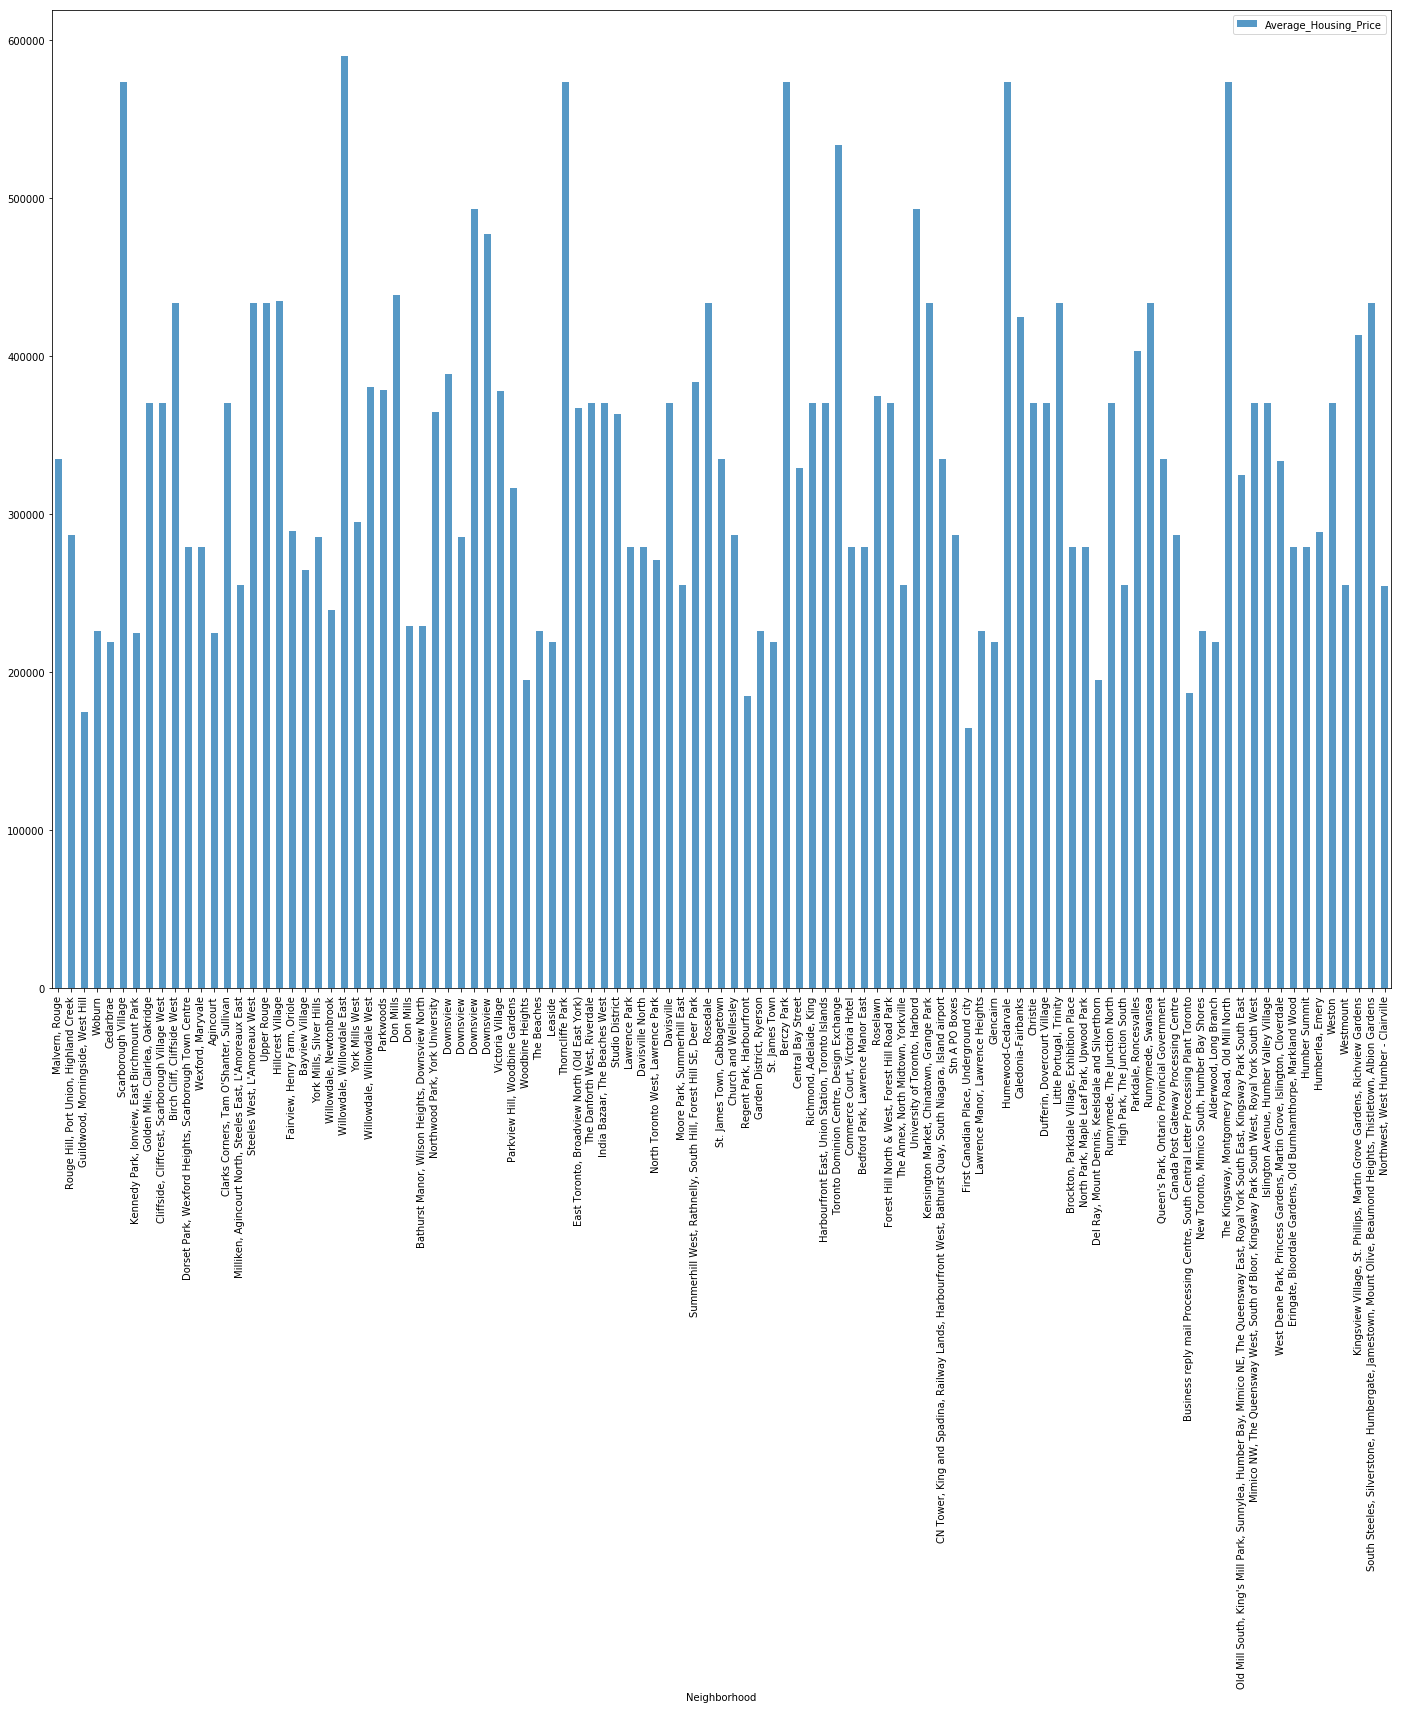

In [117]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [118]:
clusters=pd.DataFrame({"Cluster1":df_1["Neighborhood"],
                      "Cluster2":df_2["Neighborhood"],
                      "Cluster4":df_3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [122]:
new_Scarborough=toronto_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df_ll["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [123]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

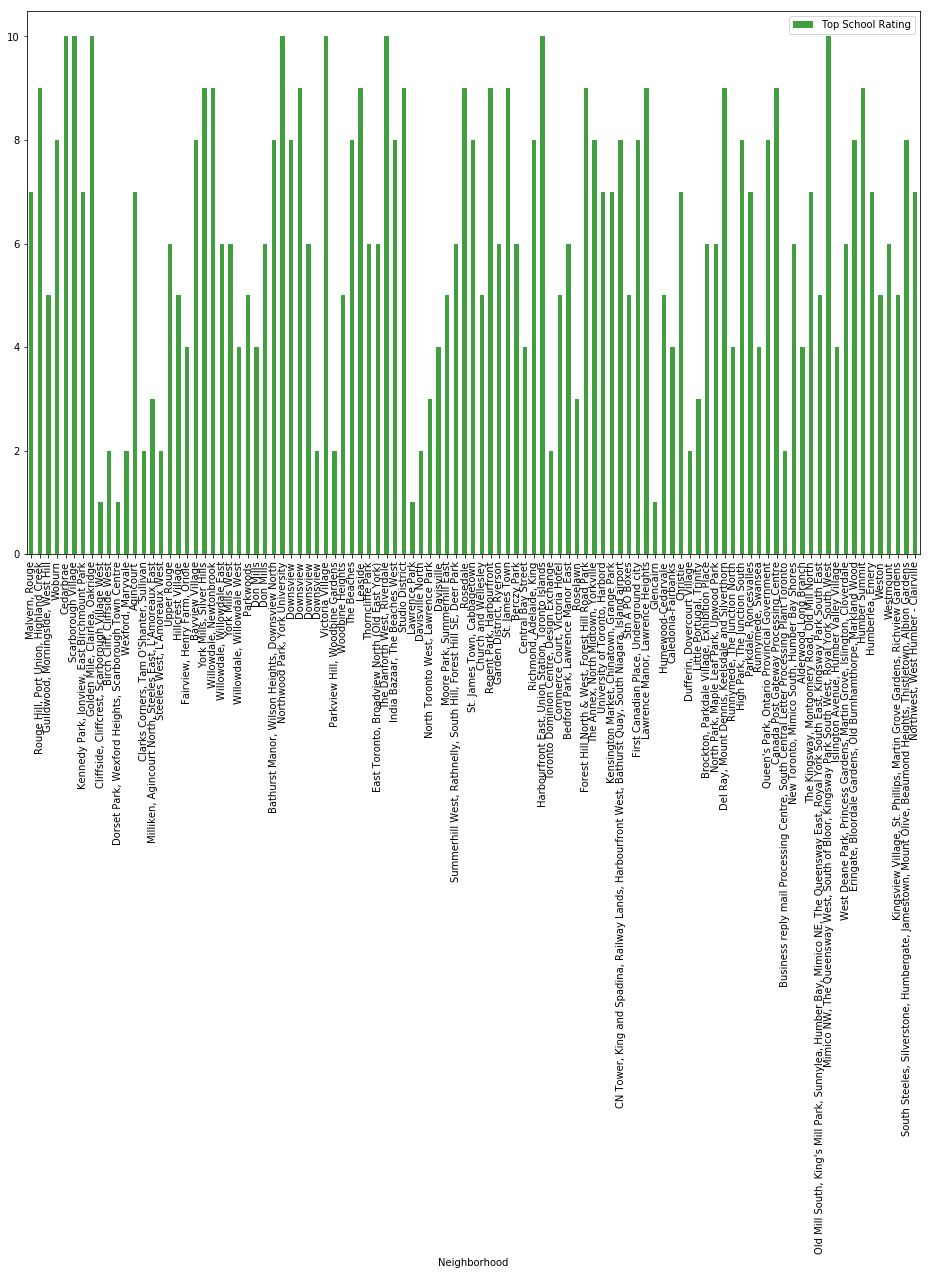

In [124]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

##### Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into  different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.